# pupil_new TLDR version

This is a notebook on explaining how to use pupil_new.py module

First, under `pipeline/python/pipeline`, you will find pupil_new.py file. This is the py file that contains the new table to be used for our automatic tracking.
The new schema name is called `pipeline_eye_DLC`. so let's import `pupil_new` first.
By the way, when you import, you will see whole bunch of backend warnings if you do so in notebook/lab (but not in ipython)... it is just a warning, not an error, so do not worry for now

In [1]:
import datajoint as dj
from pipeline import pupil_new, pupil

Loading local settings from pipeline_config.json
Connecting donnie@10.28.0.34:3306


/usr/local/lib/python3.6/dist-packages/deeplabcut/__init__.py:22: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.6/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.6/dist-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.6/dist-packages/tornado/pla

DLC loaded in light mode; you cannot use the labeling GUI!
DLC loaded in light mode; you cannot use the relabeling GUI!


/usr/local/lib/python3.6/dist-packages/deeplabcut/utils/visualization.py:15: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.6/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.6/dist-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.6/dist-packages/

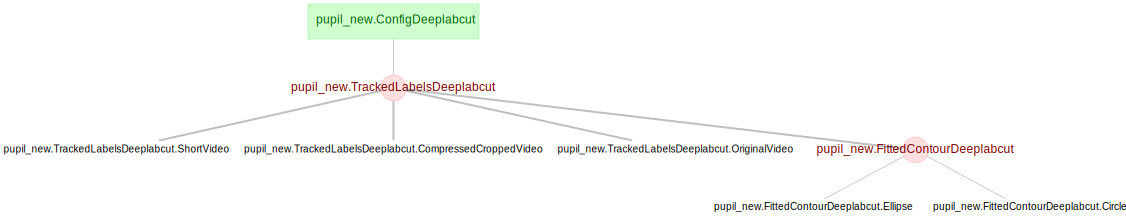

In [4]:
dj.ERD(pupil_new.schema)

## How to obtain center and radius of pupil

In [24]:
import numpy as np
from functools import partial

def fill_nans(x, preserve_gap=None):
    """
    :param x:  1D array  -- will
    :return: the array with nans interpolated
    The input argument is modified.
    """
    if preserve_gap is not None:
        assert preserve_gap % 2 == 1, 'can only efficiently preserve odd gaps'
        keep = np.convolve(np.convolve(1 * np.isnan(x), np.ones(preserve_gap), mode='same') == preserve_gap,
                           np.ones(preserve_gap, dtype=bool), mode='same')
    else:
        keep = np.zeros(len(x), dtype=bool)

    nans = np.isnan(x)

    x[nans] = 0 if nans.all() else np.interp(nans.nonzero()[0], (~nans).nonzero()[0], x[~nans])
    x[keep] = np.nan
    return x

def load_eye_traces(key):
    # if you wanna use ellipse info, change to pupil_new.FittedContourDeeplabcut.Ellipse but now it returns, major_radius and minor_radius. 
    # for consistency, you probably wanna stick with Circle atm.
    r, center = (pupil_new.FittedContourDeeplabcut.Circle() & key).fetch('radius', 'center', order_by='frame_id ASC')
    detectedFrames = ~np.isnan(r)
    xy = np.full((len(r), 2), np.nan)
    xy[detectedFrames, :] = np.vstack(center[detectedFrames])
    xy = np.vstack(map(partial(fill_nans, preserve_gap=3), xy.T))
    if np.any(np.isnan(xy)):
#         log.info('Keeping some nans in the pupil location trace')
        print('Keeping some nans in the pupil location trace')
    pupil_radius = fill_nans(r.squeeze(), preserve_gap=3)
    if np.any(np.isnan(pupil_radius)):
#         log.info('Keeping some nans in the pupil radius trace')
        print('Keeping some nans in the pupil radius trace')

    eye_time = (pupil.Eye() & key).fetch1('eye_time').squeeze()
    return pupil_radius, xy, eye_time

In [25]:
key = dict(animal_id = 20892, session=9, scan_idx=10)

pupil_radius, xy, eye_time = load_eye_traces(key)

Keeping some nans in the pupil location trace
Keeping some nans in the pupil radius trace


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


In [29]:
%matplotlib inline
import matplotlib.pyplot as plt

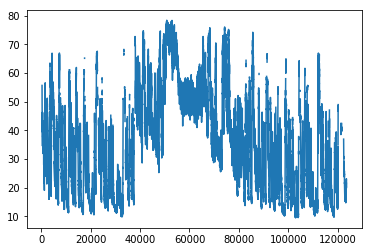

In [30]:
plt.plot(pupil_radius)

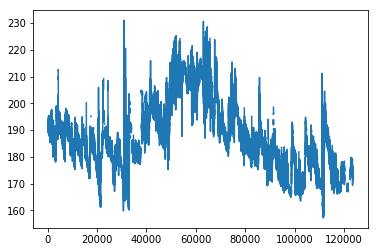

In [32]:
plt.plot(xy[0])

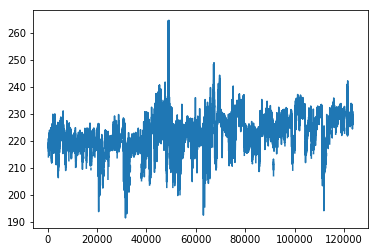

In [33]:
plt.plot(xy[1])

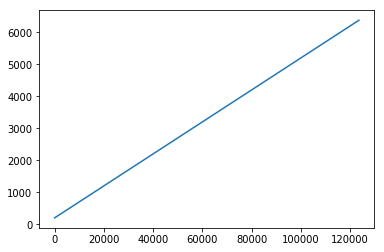

In [34]:
plt.plot(eye_time)